In [303]:
import sys
sys.path.append('./library') # age_gender_predictor
sys.path.append('../.env/lib/python2.7/site-packages')
import re
import os
import json
import math
import pickle
import numpy as np
import pandas as pd
import age_gender_predictor
from datetime import datetime, timedelta

# Load Data

In [57]:
def load(folder, col = [ 'name', 'text', 'emotion','emotion_2','ambiguous', 'polarity', 'dt']):
    return [pd.read_csv(folder + file_name, delimiter = '\t', names = col, parse_dates=True) for file_name in os.listdir(folder)]

### Regular

In [294]:
regular_clean = load('normal_900/', col = [ 'name', 'text', 'polarity','emotion','emotion_2','ambiguous', 'dt'])

print(len(regular_clean))

994


### Bipolar

In [198]:
bipolar_clean = load('Bipolar_all/')

print(len(bipolar_clean))

172


### Recent

In [49]:
recent_clean = load('mention_recent_bipolar/')

print(len(recent_clean))

41


### Diagnosed time

In [74]:
def loadDiagnosed(filename):
    with open(filename) as f:
        time_dict = {}
        for line in f.readlines():
            user, time = line.strip().split('\t')
            time_len = len(time.split('/'))
            if time_len == 3:
                time_dict[user] = datetime.strptime(time, "%Y/%m/%d") 
            elif time_len == 2:
                time_dict[user] = datetime.strptime(time, "%Y/%m")
    return time_dict
            

In [75]:
bipolar_diagnosed_time = loadDiagnosed('bipolar_list')
recent_bipolar_time = loadDiagnosed('mention_recent_patient')

In [108]:
type(regular_clean[0].index[0])

pandas.tslib.Timestamp

# Process Time Period

In [256]:
def checkTimeLength(groups, time = 2):
    """
    Input time unit is month
    """
#     return [group for group in groups ((group.index[-1]-group.index[0]).days/ 30.0) >= time]   
    result = []
    for group in groups:
        try:
            if ((group.index[-1]-group.index[0]).days/ 30.0) >= time-1:
                result.append(group)
        except:
            print(group)
    return result

def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values

def filterTime(groups, period, ref_time_dict = None, spam_threshold=0.5 , tweets_threshold=100):
    """
    Groups [list] is a list of timeSeries data of each user
    
    period [int] is how many month you want
    
    ref_time [datetime] reference time, here is diagnosed time
    """
    
    """Segment Period"""
    res_groups = []
    if ref_time_dict != None:
        base = 4.4
        if period != 2:
            delta_x = (15 - period)/6.0
            bef = base * (12 - delta_x * 5)
            after = base * (3- delta_x * 1)
        else:
            bef = 6
            after = 2
        for i, group in enumerate(groups):
            try:
                base_time = ref_time_dict.get(group.name[0])
            except:
                print(i)
            if base_time == None:
                print(group.name[0])
                continue
            temp_group = group[group.index <= base_time + timedelta(weeks = after)] # After diagnosed
            temp_group = temp_group[temp_group.index >= base_time - timedelta(weeks = bef)] # Before diagnosed
            if temp_group.shape[0] > 0:
                res_groups.append(temp_group)
    else:
        res_groups = [group[group.index >= group.index[-1] - timedelta(weeks = 65)] for group in groups]
    
    res_groups = checkTimeLength(res_groups, period)
    
    """Check spam and tweets_num"""
    new_group = []
    for group in res_groups:
        http_rows = getHTTPRows(group)
        average_http_count = np.sum(http_rows) / group.shape[0]
        if (average_http_count < spam_threshold) and (group.shape[0] > tweets_threshold):
            new_group.append(group)
        
    return new_group
    

In [299]:
regular15 = filterTime(regular_clean, 15)
regular12 = filterTime(regular_clean, 12)
regular9 = filterTime(regular_clean, 9)
regular6 = filterTime(regular_clean, 6)
regular3 = filterTime(regular_clean, 3)
regular2 = filterTime(regular_clean, 2)

print('15month:{}\n12month:{}\n9month:{}\n6month:{}\n3month:{}\n2month:{}'.format(len(regular15), len(regular12), len(regular9), len(regular6), len(regular3), len(regular2)))

15month:543
12month:578
9month:596
6month:603
3month:612
2month:614


In [263]:
bipolar15 = filterTime(bipolar_clean, 15, ref_time_dict = bipolar_diagnosed_time)
bipolar12 = filterTime(bipolar_clean, 12, ref_time_dict = bipolar_diagnosed_time)
bipolar9 = filterTime(bipolar_clean, 9, ref_time_dict = bipolar_diagnosed_time)
bipolar6 = filterTime(bipolar_clean, 6, ref_time_dict = bipolar_diagnosed_time)
bipolar3 = filterTime(bipolar_clean, 3, ref_time_dict = bipolar_diagnosed_time, tweets_threshold = 80)
bipolar2 = filterTime(bipolar_clean, 2, ref_time_dict = bipolar_diagnosed_time, tweets_threshold = 60)
print('15month:{}\n12month:{}\n9month:{}\n6month:{}\n3month:{}\n2month:{}'.format(len(bipolar15), len(bipolar12), len(bipolar9), len(bipolar6), len(bipolar3), len(bipolar2)))

15month:105
12month:112
9month:118
6month:123
3month:134
2month:134


# Feature

### Age & Gender

In [265]:
#Age and gender Distribution
def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

### Social

In [268]:
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    if total_tweets == 0: return 0.0
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_tweets / float(total_duration)
    except:
        result = total_tweets / 1.0
    return result

def getLateTweetRate(timeSeries):
    total_late = 0
    for index in timeSeries.index:
        if int(index.hour) <6:
            total_late += 1
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_late / float(total_duration)
    except:
        result = total_late / 1.0
    return result

def getMentionRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / float(total_tweets)

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)
    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": [], "long_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
        try:
            social_features["long_tweets_rate"].append(total_dict[str(timeSeries['name'][0])])
        except:
            print('No found in long_term ' + str(timeSeries['name'][0]))
            social_features["long_tweets_rate"].append(0.0)
    return social_features

def getGBSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        
    return social_features

def getNoLongSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
        
    return social_features

### Polarity

In [269]:
def getFlipsCount(timeSeries, upperbound=120, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / float(total_tweets)

def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / float(total_tweets)

def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        try:
            tweets_length = float(timeSeries.shape[0])
        except:
            print 'error'
            print timeSeries
            break
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity

def comboTracker(timeSeries, attribute= "polarity", lowerbound = 120):
    array = timeSeries[attribute]
#     the polarity of starter
    starter = array[0]
    combo = 1
    result = []
    i = 0 
#     begin from second one in the array
    for cursor in array[1:]:
        i += 1
        if starter == cursor and timeSeries["dt"][i-1] < lowerbound:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

### Emotion

In [270]:
def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    if float(filtered_emotions.shape[0]) == 0:
        divider = 1.0
    else:
        divider = float(filtered_emotions.shape[0])
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / divider
    return emotions_count

def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts



### Long term

In [271]:
# 8 weeks sliding windows, move 1 week per time
def slideWindows(timeline, start):
    
    limit = start + timedelta(weeks=8)
    
    status = False
    if timeline.index[-1] < limit: status = True
    
    new_start = start + timedelta(weeks=1)
    
    return timeline[timeline.index < limit], new_start, timeline[timeline.index > new_start],status
    
        
def getTimeSeries(timeline):
    timeSeries_list = []
    start = timeline.index[0]
    
    while True:
        timeSeries, start, timeline, status = slideWindows(timeline, start)
        timeSeries_list.append(timeSeries)
        if status: break
            
    return timeSeries_list

In [272]:
bd_dict = {}
regular_dict = {}
for i, bd_timeline in enumerate(bipolar_clean):
    try:
        tweets_rate_array = np.asarray([getTweetRate(timeSeries) for timeSeries in getTimeSeries(bd_timeline)])
    except:
        tweets_rate_array = np.asarray([0.0, 0.0])
    bd_dict[str(bd_timeline['name'][0])] = np.ptp(tweets_rate_array)
    
for i, regular_timeline in enumerate(regular_clean):
    try:
        tweets_rate_array = np.asarray([getTweetRate(timeSeries) for timeSeries in getTimeSeries(regular_timeline)])
    except:
        tweets_rate_array = np.asarray([0.0, 0.0])
    regular_dict[str(regular_timeline['name'][0])] = np.ptp(tweets_rate_array)

total_dict = {}
total_dict.update(bd_dict)
total_dict.update(regular_dict)
# del bd_dict
# del regular_dict

## LIWC

In [276]:
#Functions for LIWC and POL features extraction:
def loads_LIWC():
    f = open("LIWC/categories.json", 'r')
    categories = json.load(f)
    f = open("LIWC/words.json", 'r')
    words = json.load(f)
    patterns_categories = {}
    for word, category in words.items():
        if word[-1] == '*':
            current_dict = patterns_categories
            for char in word:
                if char == '*':
                    #current_dict = category
                    pre_dict[word[-2]] = category
                    break
                
                elif char not in current_dict:
                    current_dict[char] = {}
                pre_dict = current_dict
                current_dict = current_dict[char]
                
    return categories, words, patterns_categories

LIWC_categories, LIWC_words, LIWC_patterns_categories = loads_LIWC()

def getLIWC_user(timeSeries):
    LIWC_counts = {}
    features = np.zeros(len(LIWC_categories),dtype=int)
    
    texts= timeSeries["text"].values
    for text in texts:
        words = text.strip().split()
        for word in words:
            category_indices = LIWC_words.get(word,[])
            if category_indices == []:
                current_dict = LIWC_patterns_categories
                for char in word[:-1]:
                    current_dict = current_dict.get(char,[])
                    if isinstance(current_dict,list):
                        category_indices = current_dict                            
                        break

            for category_index in category_indices:
                category_name = LIWC_categories[category_index]
                LIWC_counts[category_name] = LIWC_counts.get(category_name,0) + 1

    for category_name in LIWC_counts:
        LIWC_counts[category_name] /= timeSeries.shape[0]
    
    return LIWC_counts

def getLIWC_group(group):
    LIWC_counts = {}
    users_num = len(group)
    for category in LIWC_categories.values():
        LIWC_counts[category] = []
    for timeSeries in group:
        user_LIWC_count = getLIWC_user(timeSeries)
      
        for category in LIWC_categories.values():
            LIWC_counts[category].append(user_LIWC_count.get(category,0))
            
    return LIWC_counts

## Group Class

In [277]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib import rcParams
from random import randint
from operator import itemgetter 
import time
rcParams['figure.figsize'] = 12, 8

In [278]:
# function to delete url
def del_url(line):
    return re.sub(r'(\S*(\.com).*)|(https?:\/\/.*)', "", line)

In [279]:
#Wrap group to be object
class Group(object):
    def __init__(self, group_name, group_data_list):
        self.name = group_name
        self.timeSerieses_list = group_data_list
        
    def getName(self):
        return self.name
    
    def getSize(self):
        return len(self.timeSerieses_list)
    
    def getTexts(self, tail_k = "all"):
        if tail_k == "all":
            return ["\n".join(map(del_url, timeSeries["text"].values)) for timeSeries in self.timeSerieses_list]
        else:
            return ["\n".join(map(del_url, timeSeries["text"].tail(tail_k).values)) for timeSeries in self.timeSerieses_list]
    
    def getGroup(self, tail_k="all"):
        if tail_k =="all":      
            return self.timeSerieses_list
        else:
            return [timeSeries.tail(tail_k) for timeSeries in self.group]

In [301]:
bipolar2_group = Group("Bipolar_2", bipolar2)
regular2_group = Group("Regular_2", regular2[:300])

bipolar3_group = Group("Bipolar_3", bipolar3)
regular3_group = Group("Regular_3", regular3[:300])

bipolar6_group = Group("Bipolar_6", bipolar6)
regular6_group = Group("Regular_6", regular6[:280])

bipolar9_group = Group("Bipolar_9", bipolar9)
regular9_group = Group("Regular_9", regular9[:270])

bipolar12_group = Group("Bipolar_12", bipolar12)
regular12_group = Group("Regular_12", regular12[:250])

bipolar15_group = Group("Bipolar_15", bipolar15)
regular15_group = Group("Regular_15", regular15[:240])

In [284]:
def getCategories(group):
    '''
    Input  : the group (Class) of user
    Output : Dictionary of feature name and feature's group pairs

    e.g.
    'tweets_rate': 'GBSocial'
    'unique_mentions': 'GBSocial'
    '''
    name2category = {}
    names = ["Emotions", "Polarity", "AgeGender", "LIWC",
             "LongSocial", "lateSocial", "GBSocial"]
    methods = [getGroupEmotions, getPolarity, getAgeGender, getLIWC_group, 
               getSocialFeature_group,  getNoLongSocialFeature_group, getGBSocialFeature_group]
    for i, method in enumerate(methods):
        if method == getLIWC_group:
            feature = {"LIWC_"+key: value for key, value in method(group.getGroup()).items()}
        else:
            feature = method(group.getGroup())
        for key in feature:
            name2category[key] = names[i]
    return name2category

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getGroupEmotions, getPolarity, getAgeGender, getLIWC_group, 
               getSocialFeature_group,  getNoLongSocialFeature_group, getGBSocialFeature_group]
    for method in methods:
        if method == getLIWC_group:
            LIWC_feature_set = {"LIWC_"+key: value for key, value in method(group.getGroup(tail_k)).items()}
            feature_set.update(LIWC_feature_set)
        else:
            feature_set.update(method(group.getGroup()))
    return feature_set

## Classifier

In [285]:
#A TF-IDF class to implement TF-IDF extraction and model training.
class TextFeatureGroups(object):
    def __init__(self, base, groups, model = "Tf-iDF"):
        self.base = base
        self.groups = groups
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
       
        base_texts = base.getTexts()
        self.text_models = []
        self.classifiers = []
        for group in groups:
            group_texts = group.getTexts()
            total_texts = base_texts  + group_texts
            if model == "Tf-iDF":
                text_model = TfidfVectorizer(stop_words="english", ngram_range = (1,2))
            text_model.fit(total_texts)    
            X = text_model.fit_transform(total_texts)  
            Y = np.array([0] * base.getSize() + [1]*group.getSize(), dtype=int)
            classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
            classifier.fit(X,Y)
            self.classifiers.append(classifier)
            self.text_models.append(text_model)
    
    def getTopFeatures(self, name, k=50):
        index = self.name_to_index[name]
        text_model = self.text_models[index]
        classifier = self.classifiers[index]
        feature_indicies = np.argsort(classifier.feature_importances_)
        vector2word = text_model.get_feature_names()
        top_words = []
        for i in range(k):
            vector = feature_indicies[-i-1]
            word = vector2word[vector]
            top_words.append(word)
        return top_words
    

    def getGroup(self,name):
        index = self.name_to_index[name]
        return self.groups[index]
            
    def classify(self,name, group):
        index = self.name_to_index[name]
        classifier = self.classifiers[index]
        text_model = self.text_models[index]
        X = text_model.transform(group.getTexts())
        return classifier.predict(X) 
    
    def getPrecision(self,name, tail_k="all", classifier = "default", n_fold=10):
        index = self.name_to_index[name]
        group = self.groups[index]
        if classifier == "default":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        #classifier = SVC(probability=True)
        #X = self.text_models[index].transform(self.base.getTexts(tail_k)+group.getTexts(tail_k))
        text_model = self.text_models[index]
        raw_X = self.base.group + group.group
        Y =  np.array([0] * self.base.getSize() + [1] * group.getSize())
        precisions = []
        
        complete_X = text_model.transform(self.base.getTexts()+group.getTexts())
        tailed_X =  text_model.transform(self.base.getTexts(tail_k)+group.getTexts(tail_k))
        
        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            
            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)

        return np.mean(precisions)
        
    
    def getLabelsScores(self, name, classifier, n_fold, consider_time = "short"):
        index = self.name_to_index[name]
        group = self.groups[index]

        SCORES = np.array([])
        LABELS = np.array([])

        
#         Based may change by situation
        if consider_time == "short":
            X = self.text_models[index].transform(self.base.getTexts()+group.getTexts())
            Y =  np.array([0] * self.base.getSize() + [1] * group.getSize())  
        elif consider_time == "long":
            X = self.text_models[index].transform(self.groups[0].getTexts()+group.getTexts())
            Y =  np.array([0] * self.groups[0].getSize() + [1] * group.getSize())  
        else:
            X = self.text_models[index].transform(self.groups[self.name_to_index["Regular_" + str(consider_time)]].getTexts()+group.getTexts())
            Y =  np.array([0] * self.groups[self.name_to_index["Regular_" + str(consider_time)]].getSize() + [1] * group.getSize())  

        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
        
    def renderPrecisionRecall(self, colors=['r','g','b',"y","c","m","#f4b642","#777777"], n_fold = 10):
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')

        for g, group in enumerate(self.groups):
            SCORES, LABELS,(X_train, X_test,Y_train, Y_test) = self.getLabelsScores(group.getName(), classifier ,n_fold)

            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)

            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test

            print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,group.getName()))
            print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,group.getName()))
            plt.plot(recall, precision, label=group.getName() , color=colors[g],linewidth=3)

        plt.legend(loc="lower right")
        plt.show()


# Build the TF-IDF class
tfidf_groups = TextFeatureGroups(regular2_group, [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, regular15_group, 
                                                  bipolar2_group, bipolar3_group, bipolar6_group, bipolar9_group, bipolar12_group, bipolar15_group])

# Extract Top 10 keywords by TF-IDF model for Bipolar and BPD
print(tfidf_groups.getTopFeatures("Bipolar_2"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_3"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_6"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_9"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_12"))
print("\n\n")
print(tfidf_groups.getTopFeatures("Bipolar_15"))

[u'shit', u'fuck', u'diagnosed bipolar', u'drunk', u'haha', u'just diagnosed', u'bipolar', u'hell', u'hehe', u'just', u'forever', u'mentalhealth', u'kiss', u'grade', u'oh god', u'crying', u'good person', u'bae', u'really', u'type', u'fucking hot', u'soo', u'miley', u'event', u'2014', u'want boyfriend', u'weird', u'doesn know', u'diagnosed', u'idk', u'guys', u'friend just', u'tho', u'kat', u'empty_tweets', u'mom', u'cramps', u'day', u'gonna', u'dont make', u'completely', u'2017', u'bleed', u'enjoy', u'burger', u'like', u'sleep', u'tumblr', u'like just', u'gay']



[u'diagnosed', u'diagnosed bipolar', u'shit', u'wanna', u'woke', u'empty_tweets', u'tumblr', u'fuck', u'just diagnosed', u'don hate', u'like idk', u'fuck love', u'alright', u'hates', u'2013', u'crying', u'gay', u'da', u'porn', u'okay', u'click', u'oh', u'fucking hate', u'bullshit', u'hated', u'cutest', u'bitches', u'say', u'tongue', u'man', u'just fuck', u'met', u'kill', u'want feel', u'talk people', u'hair', u'pussy', u'bc', 

## Random Forest

In [286]:
class POLFeaturerGroups(object):
    
    @staticmethod
    def transform(self, ):
        features_dict = getAllFeature(group)
        
    
    def __init__(self, base, groups):
        feature2categories = getCategories(base)
        self.groups = groups
        self.base = base
        self.categories = set(feature2categories.values())
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
        self.base_name = base.getName()
        self.index2feature = []
        base_feature_dict = getAllFeature(base)
        self.base_feature = np.zeros((base.getSize(),len(base_feature_dict)), dtype = float)
#         
        for name, values in base_feature_dict.items():
            cursor = len(self.index2feature)
            self.base_feature[:,cursor] = values
            category = feature2categories[name]
            self.index2feature.append((name, category))
        
        self.features = [self.group2feature(group) for group in groups]
#         user_name
        self.groups_user_name = []
        for group in groups:
            group_user_name = []
            for timeSeries in group.getGroup():
                group_user_name.append(timeSeries['name'][0])
            self.groups_user_name.append(group_user_name)
        
        self.base_user_name = []
        for timeSeries in base.getGroup():
            self.base_user_name.append(timeSeries['name'][0])
            
    def addgroup(self, group):
        group_user_name = []
        for timeSeries in group.getGroup():
            group_user_name.append(timeSeries['name'][0])
        self.groups_user_name.append(group_user_name)
        
        self.name_to_index = {group.getName(): len(name_to_index)}
        print(group.getName() + ' is added!')
        return True
        
    def group2feature(self, group, tail_k="all", selection = "all"):
        features_dict = getAllFeature(group, tail_k)
        feature = np.zeros((group.getSize(),len(self.index2feature)),dtype=float)
        for cursor, (name,category) in enumerate(self.index2feature):
            value = features_dict[name]
            feature[:,cursor] = value
        if selection == "all":
            return feature
        else:
            return feature[:,selection]   

    def getPrecision(self,name,selection="all",tail_k="all",n_fold=10,classifier = "forest"):
        complete_X, Y = self.getLabeledData(name, selection)
        index = self.name_to_index[name]
        group = self.groups[index]
        tailed_X = preprocessing.scale(self.group2feature(self.base + group, tail_k=tail_k, selection = selection))
        complete_X = preprocessing.scale(complete_X)
        
        tailed_X[np.isinf(tailed_X)] = 0
        tailed_X[np.isnan(tailed_X)] = 0
        
        precisions = []
        if classifier == "forest":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
  
        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            imputer = Imputer()
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)
            
        return np.mean(precisions)
            
    def getLabeledData(self,name, selection = "all", consider_time = "short"):
#         print('Get Label Data - Name: {}, Consider Time: {}, Selection: {}'.format(name, consider_time, selection))
        if selection is "all":
            selection = xrange(len(self.index2feature))
            
        if consider_time == "short":        
            base_feature = self.base_feature[:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]
            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
    #         Y = np.array([(0,-1)]*base_length + [(1,i) for i,_ in enumerate(self.getGroupUserName())])
            Y = np.array([(0,i) for i,_ in enumerate(self.getBaseUserName())] + [(1,i) for i,_ in enumerate(self.getGroupUserName(1))])
            return X, Y
        elif consider_time == "long":
            base_index = self.name_to_index["Regular_15"]
            base_feature = self.features[base_index][:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]

            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
            Y = np.array([(0,i) for i,_ in enumerate(self.getGroupUserName(base_index))] + [(1,i) for i,_ in enumerate(self.getGroupUserName(index))])
            return X, Y
        else:
            base_index = self.name_to_index["Regular_"+str(consider_time)]
            base_feature = self.features[base_index][:,selection]
            base_length = base_feature.shape[0]
            index = self.name_to_index[name]
            feature = self.features[index][:,selection]

            X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
            X[0:base_length ,:] = base_feature
            X[base_length:,:] = feature
            Y = np.array([(0,i) for i,_ in enumerate(self.getGroupUserName(base_index))] + [(1,i) for i,_ in enumerate(self.getGroupUserName(index))])
            return X, Y 

            
    def getFeatureImportance_all(self,name):
        X, Y = self.getLabeledData(name)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        features_indicies = np.argsort(classifier.feature_importances_)
        feature_names = [self.index2feature[i] for i in features_indicies ]
        return feature_names[::-1]
    
    def getFeature(self, name, selection="all"):
        if selection is "all":
            selection = list(range(len(self.index2feature)))
        index = self.name_to_index[name]
        feature =  self.features[index]
        return feature[:, selection]
    
    def classify(self,name, target_name, selection="all"):
        X, Y = self.getLabeledData(name, selection)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        test_x = self.getFeature(target_name,selection)
        return classifier.predict(test_x)
       
    def getLabelsScores(self, name, classifier, n_fold, selection, consider_time = "short"):
        SCORES = np.array([])
        LABELS = np.zeros(shape=(0,2))
        
        X, Y = self.getLabeledData(name, selection, consider_time)
        sss = StratifiedShuffleSplit(Y[:,0], n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            X_train, X_test           = X[train_index], X[test_index]
            Y_train, Y_test           = Y[train_index][:,0], Y[test_index][:,0]
            Y_train_name, Y_test_name = Y[train_index][:,1], Y[test_index][:,1]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y[test_index]))
        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test, Y_train_name, Y_test_name)
    
    def renderPrecisionRecall_all(self, name, colors=['r','g','b',"y","c","m","#f4b642","#777777"], n_fold = 100, consider_time = "short"):
        classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        ax.title.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        categories = list(self.categories) + ["All"]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category == feature_category]
            
            SCORES, LABELS, (X_train, X_test,Y_train, Y_test, Y_train_name, Y_test_name) = self.getLabelsScores(name, classifier,n_fold, selection, consider_time)
            precision, recall, _ = precision_recall_curve(LABELS[:,0], SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS[:,0], SCORES)
            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test
           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=2)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()

    def getSeperateScores(self, name, classifier, n_fold, selection):
        SCORES = np.array([])
        LABELS = np.array([])

        X, Y = self.getLabeledData(name, selection)

        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.1, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
    
    def getGroupUserName(self,group_num = 0):
        return self.groups_user_name[group_num]
    
    def getIndex2Feature(self):
        return self.index2feature
    
    def getBaseUserName(self):
        return self.base_user_name
    
    def getName2Index(self):
        return self.name_to_index

In [304]:
pol_groups = POLFeaturerGroups(regular2_group, [regular2_group, regular3_group, regular6_group, regular9_group, regular12_group, regular15_group, 
                                                  bipolar2_group, bipolar3_group, bipolar6_group, bipolar9_group, bipolar12_group, bipolar15_group])

270 Normal and 120 Bipolar_2 in Training Data
30 Normal and 14 Bipolar_2 in Test Data



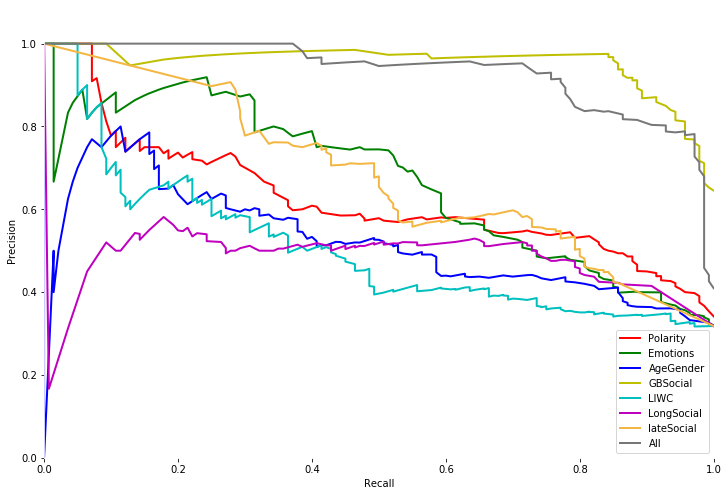

270 Normal and 120 Bipolar_3 in Training Data
30 Normal and 14 Bipolar_3 in Test Data



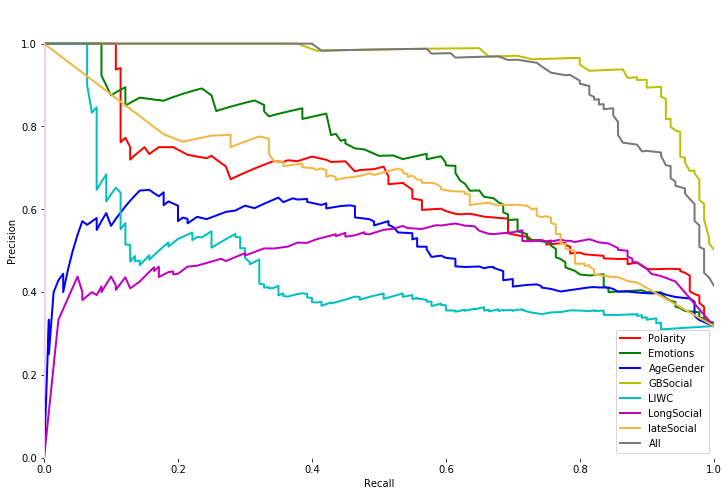

252 Normal and 110 Bipolar_6 in Training Data
28 Normal and 13 Bipolar_6 in Test Data



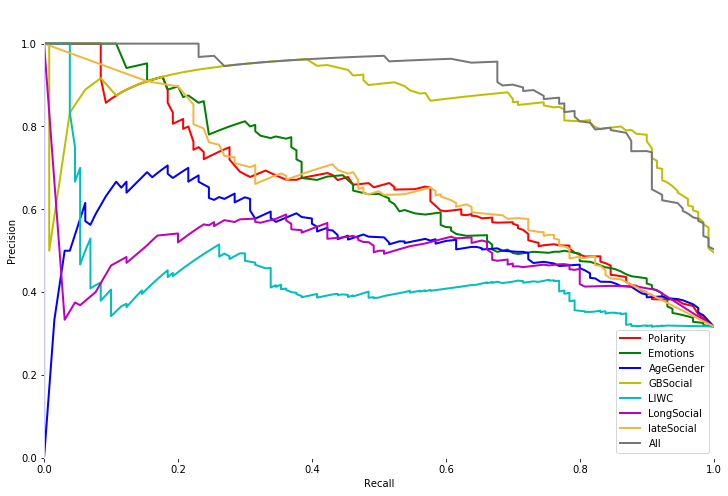

243 Normal and 106 Bipolar_9 in Training Data
27 Normal and 12 Bipolar_9 in Test Data



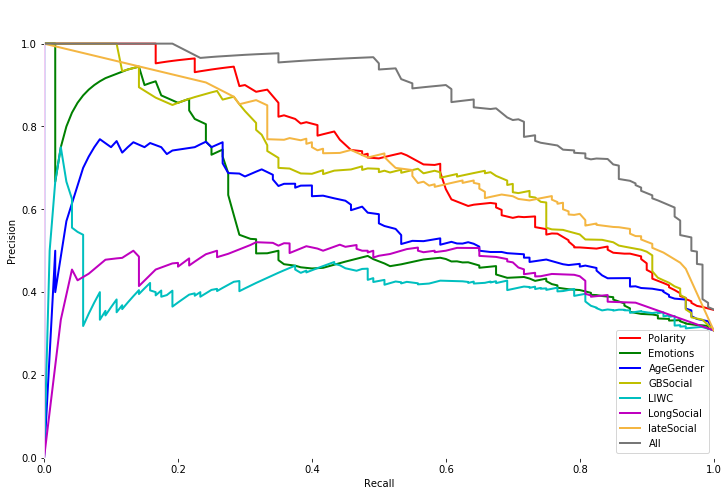

224 Normal and 101 Bipolar_12 in Training Data
26 Normal and 11 Bipolar_12 in Test Data



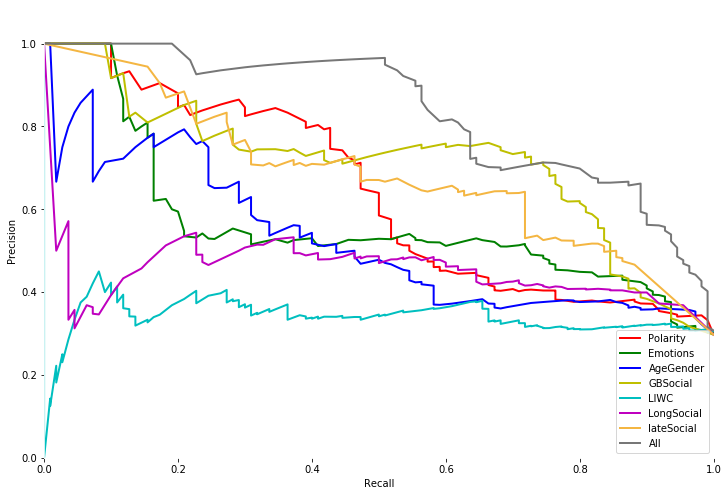

216 Normal and 94 Bipolar_15 in Training Data
24 Normal and 11 Bipolar_15 in Test Data



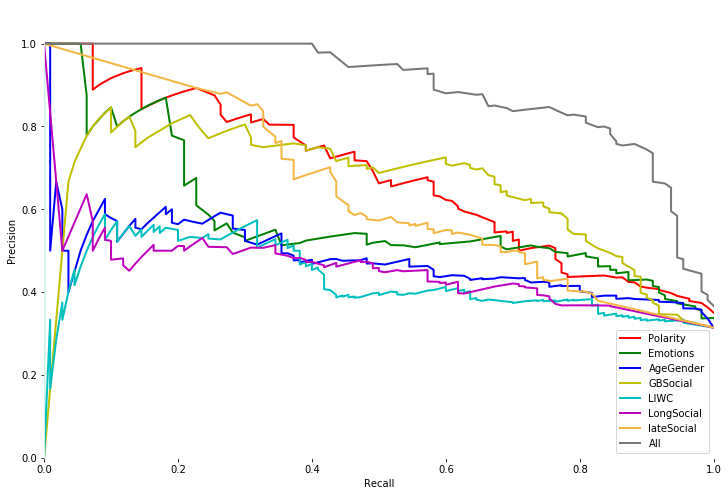

In [306]:
#Compare the performance of each Pattern of Life components and LIWC
pol_groups.renderPrecisionRecall_all("Bipolar_2", n_fold=10, consider_time = 2)
pol_groups.renderPrecisionRecall_all("Bipolar_3", n_fold=10, consider_time = 3)
pol_groups.renderPrecisionRecall_all("Bipolar_6", n_fold=10, consider_time = 6)
pol_groups.renderPrecisionRecall_all("Bipolar_9", n_fold=10, consider_time = 9)
pol_groups.renderPrecisionRecall_all("Bipolar_12", n_fold=10, consider_time = 12)
pol_groups.renderPrecisionRecall_all("Bipolar_15", n_fold=10, consider_time = 15)

## Evaluation

In [307]:
index2feature = pol_groups.index2feature

def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            #removed_features.append(name)
            pass
        elif any(name == x for x in excluded_index):
            #removed_features.append(name)
            pass

        else:                   
            selection.append(i)
    return selection


#ROC chart of three models:
# def renderROC(scores, labels,disorder ,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted']):
def renderROC(scores, labels,disorder ,names,
              linestyle=['solid','solid','solid','solid','dashdot','dashdot','dashdot','dashdot'],
              colors = None,
              linewidth = 3,
              transparent = 1):
    
    fig, ax = plt.subplots()
    print("Under curve area")
    for i,(score, label) in enumerate(zip(scores, labels)):
        fpr, tpr, _ = roc_curve(label,score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        
        if colors:
            plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=linewidth, color=colors[i], alpha=transparent)
        else:
            plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=linewidth, alpha=transparent)

        print("\t{:15} : {}".format(names[i],roc_auc))

   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

# , linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['r','g','b',"y","c","m","#f4b642","#777777"]
# def renderPRC(scores, labels, disorder ,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = None):
def renderPRC(scores, labels, disorder ,names,
              linestyle=['solid','solid','solid','solid','dashdot','dashdot','dashdot','dashdot'],
              colors = None,
              linewidth = 3,
              transparent = 1):
    
    fig, ax = plt.subplots()
    print("Average Precision")
    for i,(score, label) in enumerate(zip(scores, labels)):        
        precision, recall, _ = precision_recall_curve(label, score, pos_label=1)
        average_precision = average_precision_score(label, score)
        
        if colors:
            plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=linewidth, color=colors[i], alpha=transparent)
        else:
            plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=linewidth, alpha=transparent)
            
        print("\t{:15} : {}".format(names[i],average_precision))

   

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

## Data Preparation

In [308]:

GBPOL_selection = getSelection(excluded_categories=["LIWC", "lateSocial", "LongSocial"])
latePOL_selection = getSelection(excluded_categories=["LIWC", "LongSocial"])
LongPOL_selection = getSelection(excluded_categories=["LIWC"])
LIWC_selection = getSelection(excluded_categories=["AgeGender", "Social", "Polarity", "Emotions", "lateSocial", "LongSocial"])

classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
name = "Bipolar"
n_fold = 50


### POL

In [309]:
POL15_scores, POL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 15)
POL12_scores, POL12_labels, _ = pol_groups.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 12)
POL9_scores, POL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 9)
POL6_scores, POL6_labels, _ = pol_groups.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 6)
POL3_scores, POL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 3)
POL2_scores, POL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=GBPOL_selection, consider_time = 2)


### LatePOL

In [310]:
latePOL15_scores, latePOL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 15)
latePOL12_scores, latePOL12_labels, _ = pol_groups.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 12)
latePOL9_scores, latePOL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 9)
latePOL6_scores, latePOL6_labels, _ = pol_groups.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 6)
latePOL3_scores, latePOL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 3)
latePOL2_scores, latePOL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=latePOL_selection, consider_time = 2)

### LongPOL

In [311]:
longPOL15_scores, longPOL15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 15)
longPOL12_scores, longPOL12_labels, _ = pol_groups.getLabelsScores(name+"_12", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 12)
longPOL9_scores, longPOL9_labels, _ = pol_groups.getLabelsScores(name+"_9", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 9)
longPOL6_scores, longPOL6_labels, _ = pol_groups.getLabelsScores(name+"_6", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 6)
longPOL3_scores, longPOL3_labels, _ = pol_groups.getLabelsScores(name+"_3", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 3)
longPOL2_scores, longPOL2_labels, _ = pol_groups.getLabelsScores(name+"_2", classifier,n_fold=n_fold, selection=LongPOL_selection, consider_time = 2)

### LIWC

In [312]:
LIWC15_scores, LIWC15_labels, _ = pol_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 15)
LIWC12_scores, LIWC12_labels, _ = pol_groups.getLabelsScores(name +"_12", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 12)
LIWC9_scores, LIWC9_labels, _ = pol_groups.getLabelsScores(name +"_9", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 9)
LIWC6_scores, LIWC6_labels, _ = pol_groups.getLabelsScores(name +"_6", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 6)
LIWC3_scores, LIWC3_labels, _ = pol_groups.getLabelsScores(name +"_3", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 3)
LIWC2_scores, LIWC2_labels, _ = pol_groups.getLabelsScores(name +"_2", classifier,n_fold=n_fold, selection=LIWC_selection, consider_time = 2)

### TFIDF

In [313]:
tfidf15_scores, tfidf15_labels, _ = tfidf_groups.getLabelsScores(name +"_15", classifier,n_fold=n_fold, consider_time = 15)
tfidf12_scores, tfidf12_labels, _ = tfidf_groups.getLabelsScores(name +"_12", classifier,n_fold=n_fold, consider_time = 12)
tfidf9_scores, tfidf9_labels, _ = tfidf_groups.getLabelsScores(name +"_9", classifier,n_fold=n_fold, consider_time = 9)
tfidf6_scores, tfidf6_labels, _ = tfidf_groups.getLabelsScores(name +"_6", classifier,n_fold=n_fold, consider_time = 6)
tfidf3_scores, tfidf3_labels, _ = tfidf_groups.getLabelsScores(name +"_3", classifier,n_fold=n_fold, consider_time = 3)
tfidf2_scores, tfidf2_labels, _ = tfidf_groups.getLabelsScores(name +"_2", classifier,n_fold=n_fold, consider_time = 2)

### POL Compare by period

Under curve area
	PoL(15month)    : 0.892008333333
	PoL(12month)    : 0.920632167832
	PoL(9month)     : 0.902500617284
	PoL(6month)     : 0.931698901099
	PoL(3month)     : 0.95522952381
	PoL(2month)     : 0.964262857143


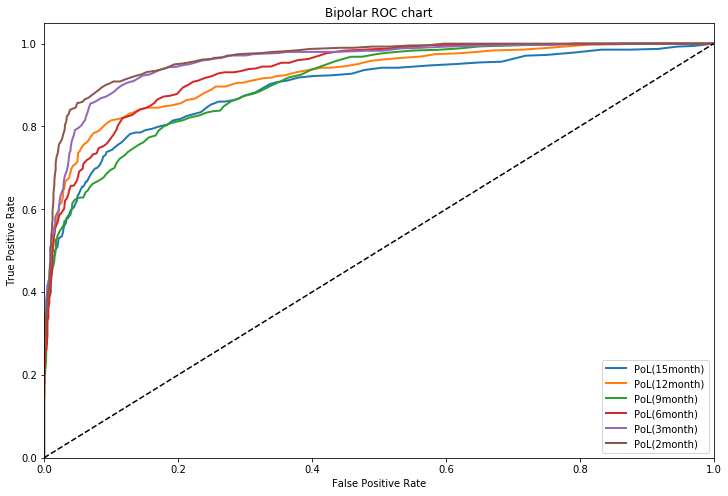

Average Precision
	PoL(15month)    : 0.84630688459
	PoL(12month)    : 0.87157949408
	PoL(9month)     : 0.838653535314
	PoL(6month)     : 0.878968090738
	PoL(3month)     : 0.919164026001
	PoL(2month)     : 0.933857726605


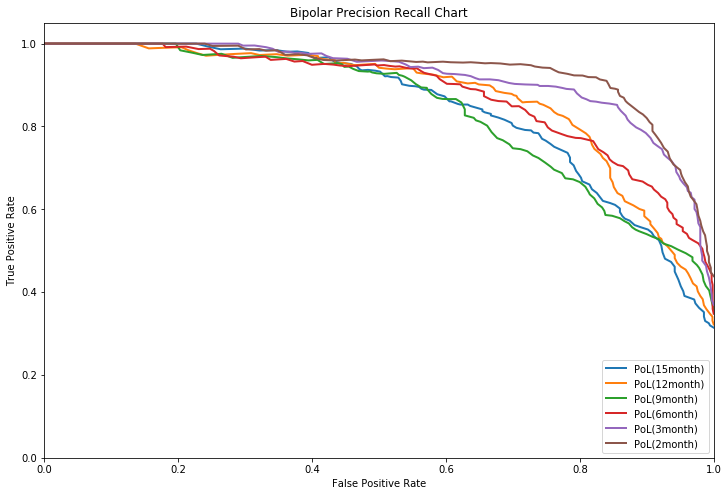

In [314]:
names = ["PoL(15month)","PoL(12month)", "PoL(9month)", "PoL(6month)","PoL(3month)", "PoL(2month)"]

bipolar_SCORES = [POL15_scores, POL12_scores, POL9_scores, POL6_scores, POL3_scores, POL2_scores]
bipolar_LABELS = [POL15_labels[:,0], POL12_labels[:,0], POL9_labels[:,0], POL6_labels[:,0], POL3_labels[:,0], POL2_labels[:,0]]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names , linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 2)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 2)


### latePOL compare by Period

Under curve area
	latePoL(15month) : 0.925602272727
	latePoL(12month) : 0.916969230769
	latePoL(9month) : 0.915028395062
	latePoL(6month) : 0.944256593407
	latePoL(3month) : 0.948022857143
	latePoL(2month) : 0.97036


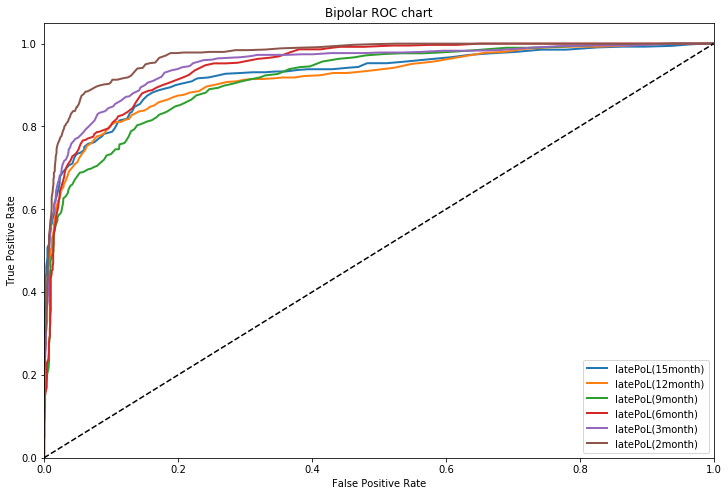

Average Precision
	latePoL(15month) : 0.894201730995
	latePoL(12month) : 0.873916986344
	latePoL(9month) : 0.852659271502
	latePoL(6month) : 0.89028645048
	latePoL(3month) : 0.911360141933
	latePoL(2month) : 0.940300711972


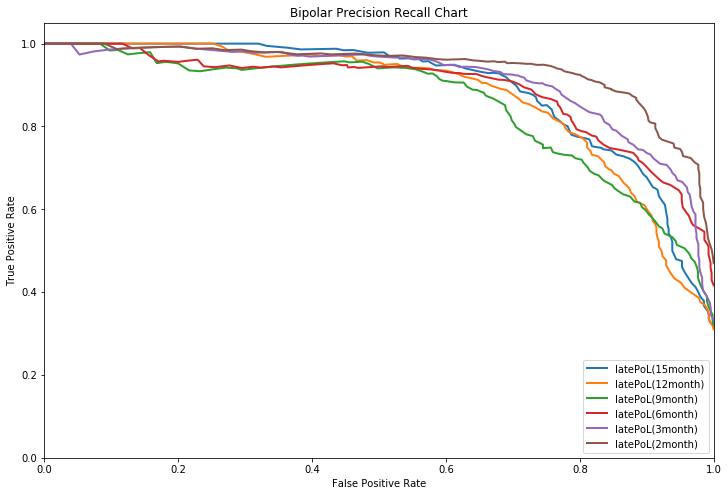

In [315]:
names = ["latePoL(15month)","latePoL(12month)", "latePoL(9month)", "latePoL(6month)","latePoL(3month)", "latePoL(2month)"]

bipolar_SCORES = [latePOL15_scores, latePOL12_scores, latePOL9_scores, latePOL6_scores, latePOL3_scores, latePOL2_scores]
bipolar_LABELS = [latePOL15_labels[:,0], latePOL12_labels[:,0], latePOL9_labels[:,0], latePOL6_labels[:,0], latePOL3_labels[:,0], latePOL2_labels[:,0]]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names , linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 2)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 2)

### LongPOL compare by Period

Under curve area
	longPoL(15month) : 0.909499242424
	longPoL(12month) : 0.901428671329
	longPoL(9month) : 0.908751234568
	longPoL(6month) : 0.94307032967
	longPoL(3month) : 0.95806
	longPoL(2month) : 0.968665714286


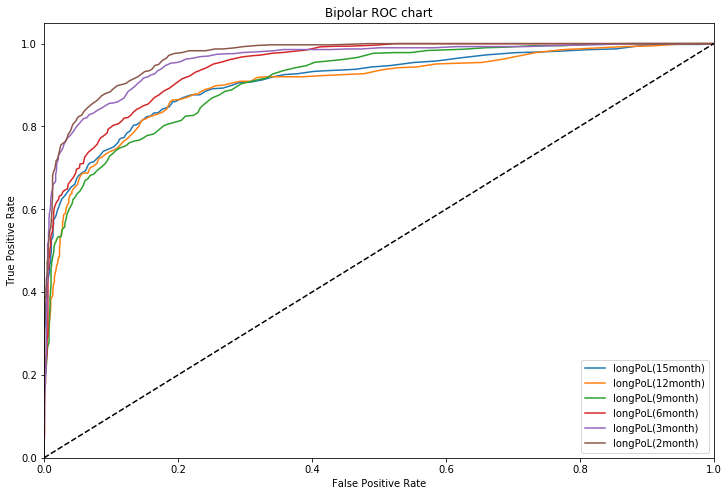

Average Precision
	longPoL(15month) : 0.86937884166
	longPoL(12month) : 0.840489285416
	longPoL(9month) : 0.843781634786
	longPoL(6month) : 0.890809357118
	longPoL(3month) : 0.92378056156
	longPoL(2month) : 0.938350316398


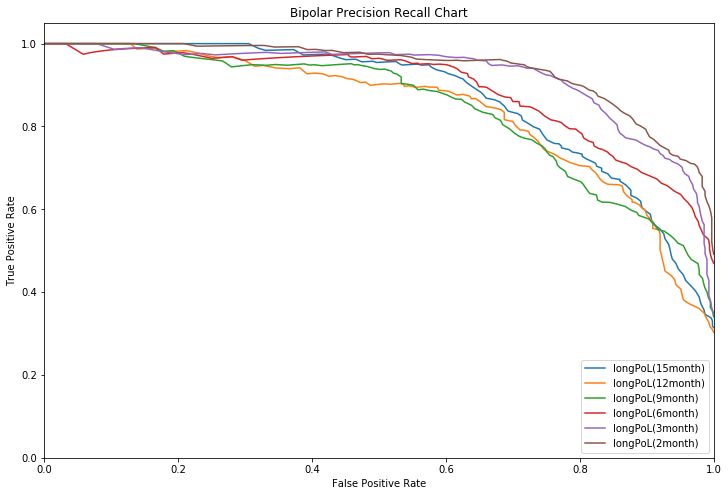

In [316]:
names = ["longPoL(15month)","longPoL(12month)", "longPoL(9month)", "longPoL(6month)","longPoL(3month)", "longPoL(2month)"]

bipolar_SCORES = [longPOL15_scores, longPOL12_scores, longPOL9_scores, longPOL6_scores, longPOL3_scores, longPOL2_scores]
bipolar_LABELS = [longPOL15_labels[:,0], longPOL12_labels[:,0], longPOL9_labels[:,0], longPOL6_labels[:,0], longPOL3_labels[:,0], longPOL2_labels[:,0]]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names , linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 1.5)  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','solid','solid','solid','solid','solid'], linewidth = 1.5)


### LIWC

Average Precision
	LIWC(15month)   : 0.672243568665
	LIWC(12month)   : 0.70661845464
	LIWC(9month)    : 0.72495338678
	LIWC(6month)    : 0.782934275545
	LIWC(3month)    : 0.856669132048
	LIWC(2month)    : 0.919100011418


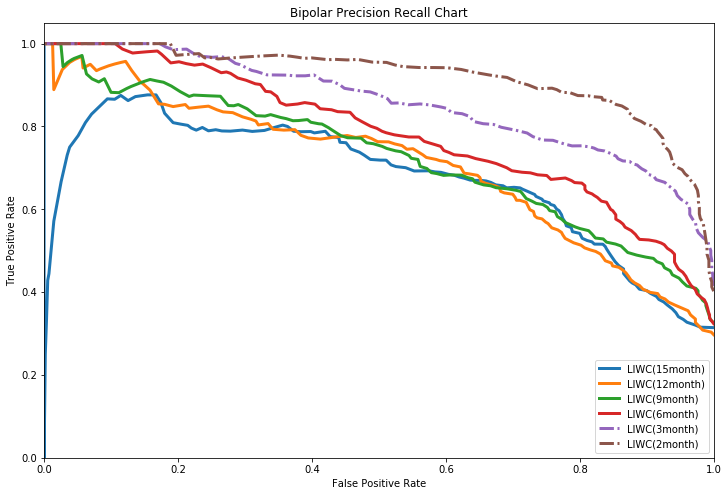

In [317]:
names = ["LIWC(15month)","LIWC(12month)", "LIWC(9month)", "LIWC(6month)","LIWC(3month)", "LIWC(2month)"]

bipolar_SCORES = [LIWC15_scores, LIWC12_scores, LIWC9_scores, LIWC6_scores, LIWC3_scores, LIWC2_scores]
bipolar_LABELS = [LIWC15_labels[:,0], LIWC12_labels[:,0], LIWC9_labels[:,0], LIWC6_labels[:,0], LIWC3_labels[:,0], LIWC2_labels[:,0]]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

### TFIDF

Average Precision
	tfidf(15month)  : 0.752850985259
	tfidf(12month)  : 0.730644085022
	tfidf(9month)   : 0.72869026895
	tfidf(6month)   : 0.685560549902
	tfidf(3month)   : 0.630783056083
	tfidf(2month)   : 0.571662575885


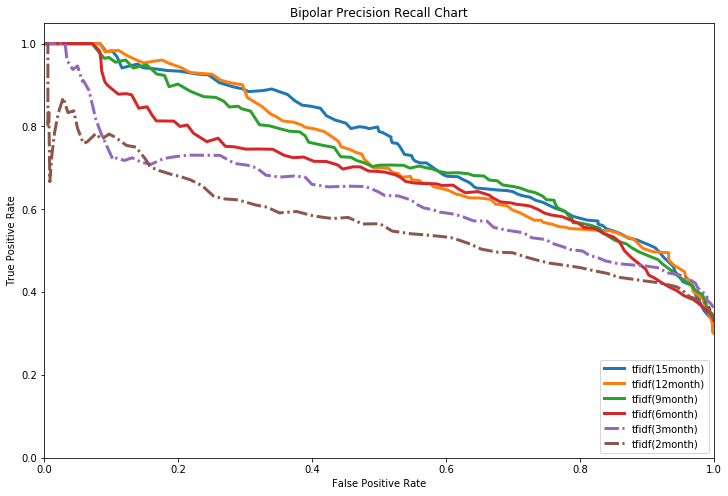

In [318]:
names = ["tfidf(15month)","tfidf(12month)", "tfidf(9month)", "tfidf(6month)","tfidf(3month)", "tfidf(2month)"]

bipolar_SCORES = [tfidf15_scores, tfidf12_scores, tfidf9_scores, tfidf6_scores, tfidf3_scores, tfidf2_scores]
bipolar_LABELS = [tfidf15_labels, tfidf12_labels, tfidf9_labels, tfidf6_labels, tfidf3_labels, tfidf2_labels]

renderPRC(bipolar_SCORES, bipolar_LABELS, name, names)

### Pol, LIWC, TFiDF

Under curve area
	PoL(15month)    : 0.892008333333
	TFIDF(15month)  : 0.80905530303
	LIWC(15month)   : 0.853182575758


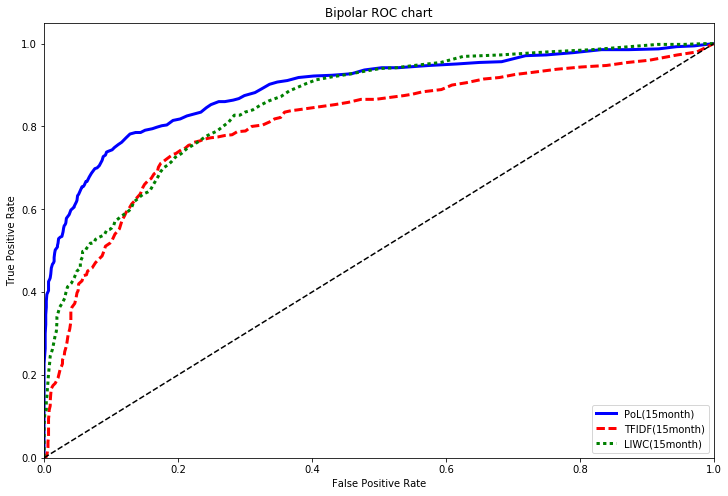

Average Precision
	PoL(15month)    : 0.84630688459
	TFIDF(15month)  : 0.672243568665
	LIWC(15month)   : 0.752850985259


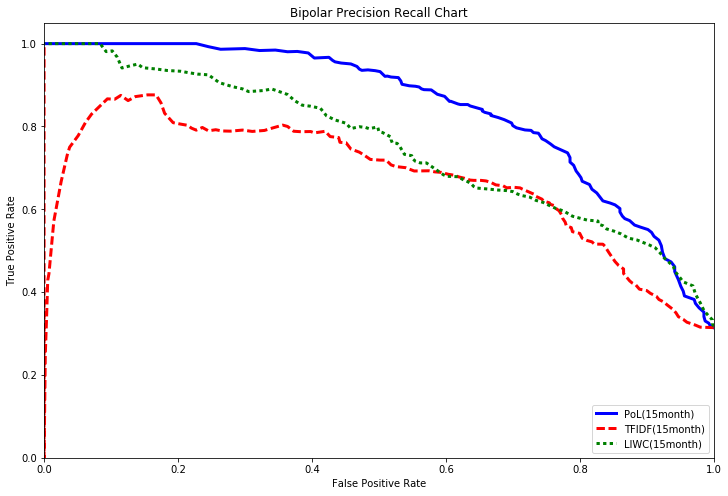

In [320]:
names = ["PoL(15month)", "TFIDF(15month)", "LIWC(15month)"]

bipolar_SCORES = [POL15_scores, LIWC15_scores, tfidf15_scores]
bipolar_LABELS = [POL15_labels[:,0], LIWC15_labels[:,0], tfidf15_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['solid','dashed','dotted','solid','dashdot','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])

Under curve area
	PoL(15month)    : 0.892008333333
	latePoL(15month) : 0.925602272727
	LongPoL(15month) : 0.909499242424
	TFIDF(15month)  : 0.80905530303
	LIWC(15month)   : 0.853182575758


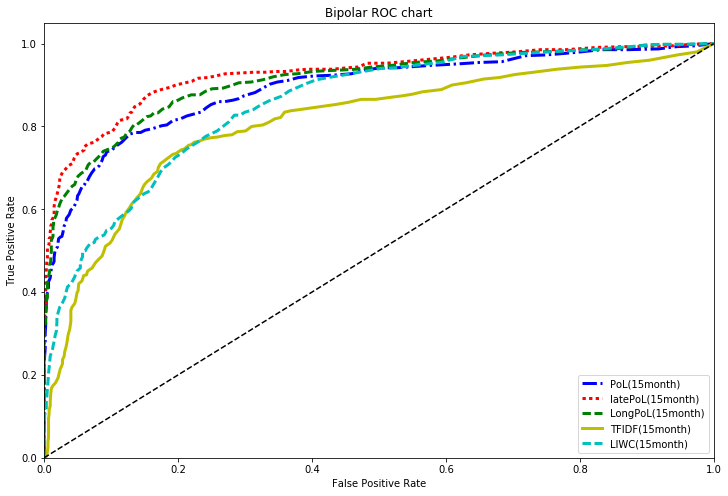

Average Precision
	PoL(15month)    : 0.84630688459
	latePoL(15month) : 0.894201730995
	LongPoL(15month) : 0.86937884166
	TFIDF(15month)  : 0.672243568665
	LIWC(15month)   : 0.752850985259


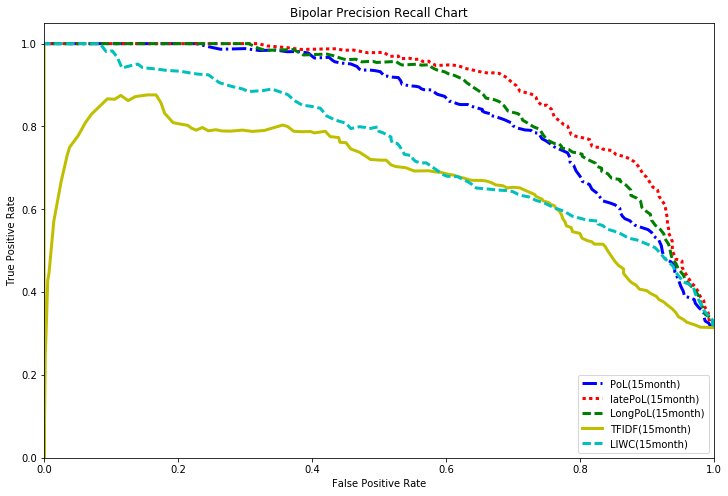

In [321]:
names = ["PoL(15month)", "latePoL(15month)", "LongPoL(15month)", "TFIDF(15month)", "LIWC(15month)"]

bipolar_SCORES = [POL15_scores, latePOL15_scores, longPOL15_scores, LIWC15_scores, tfidf15_scores]
bipolar_LABELS = [POL15_labels[:,0], latePOL15_labels[:,0], longPOL15_labels[:,0], LIWC15_labels[:,0], tfidf15_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names, linestyle=['dashdot',':','--','solid','dashed','','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])  
renderPRC(bipolar_SCORES, bipolar_LABELS, name, names, linestyle=['dashdot',':','--','solid','dashed','solid','--','dashed','dotted'], colors = ['b','r','g',"y","c","m","#f4b642","#777777"])